In [1]:
#from sklift.datasets import fetch_hillstrom
import pandas as pd
import numpy as np 
from scipy import stats
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV
from sklearn.metrics import classification_report
from causalml.metrics import plot_gain,auuc_score
from scipy.stats import spearmanr
from sklearn.model_selection import (
    RandomizedSearchCV,GridSearchCV,cross_val_score,train_test_split,GroupKFold,
    StratifiedShuffleSplit,cross_validate)
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel,ClassTransformation,TwoModels
from sklift.metrics import uplift_by_percentile
from sklift.viz import plot_uplift_by_percentile
from sklift.viz import plot_qini_curve,plot_uplift_curve
from sklift.metrics import qini_auc_score,uplift_auc_score

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.dataset import *
from causalml.metrics import *

import scipy
import seaborn as sns
import time
import warnings
from matplotlib import pyplot as plt
from joblib import dump, load
warnings.filterwarnings("ignore")
%matplotlib inline  

背景：
这是 MineThatData 电子邮件分析和数据挖掘挑战数据集的副本。
该数据集包含 64,000 名在十二个月内最后一次购买的客户。 客户参与了电子邮件测试。
1/3 被随机选择接收以男士商品为特色的电子邮件活动。
1/3 被随机选择接收以女性商品为特色的电子邮件活动。
1/3 被随机选择不接收电子邮件活动。
在电子邮件活动之后的两周内，对结果进行了跟踪。 你的工作是告诉全世界男士或女士电子邮件活动是否成功。

数据集由 Kevin Hillstorm 提供。 Kevin 是 MineThatData 的总裁，该公司是一家帮助 CEO 了解客户、广告、产品、品牌和渠道之间复杂关系的咨询公司。

In [2]:
data = pd.read_csv('../hillstrom_data/womens_exp_data.csv', sep='\t')
data.sample()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel_phone,channel_web,segment_mens,segment_womens,visit,conversion,spend,history_norm
10501,8,50,29.99,0,1,1,1,1,0,0,1,0,0,0.0,3.434457


In [3]:
len(data)

In [4]:
data.describe()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel_phone,channel_web,segment_mens,segment_womens,visit,conversion,spend,history_norm
count,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000,42693.0,42693.000000,42693.000000,42693.000000,42693.000000,42693.000000
mean,5.758789,240.377814,241.711212,0.551074,0.548872,2.252454,0.502612,0.561357,0.560092,0.0,0.500949,0.128827,0.007285,0.865398,5.073125
std,3.504745,229.779937,254.040262,0.497390,0.497612,0.696275,0.499999,0.496227,0.496382,0.0,0.500005,0.335012,0.085039,13.472998,1.056974
min,1.000000,50.000000,29.990000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,3.434457
25%,2.000000,50.000000,65.160000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,4.227593
50%,5.000000,150.000000,158.460000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,5.140269
75%,9.000000,275.000000,326.050000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,5.884771
max,12.000000,1000.000000,3345.930000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,499.000000,8.308546


In [5]:
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel_phone,channel_web,segment_mens,segment_womens,visit,conversion,spend,history_norm
0,10,150,142.44,1,0,2,0,1,0,0,1,0,0,0.0,5.030560
1,7,150,180.65,0,1,2,1,0,1,0,1,0,0,0.0,5.275267
2,2,50,45.34,1,0,3,0,0,1,0,1,0,0,0.0,3.856478
3,6,150,134.83,0,1,2,0,1,0,0,1,1,0,0.0,4.974069
4,9,275,280.20,1,0,2,1,1,0,0,1,0,0,0.0,5.728146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42688,3,425,487.10,0,1,2,1,1,0,0,0,0,0,0.0,6.300304
42689,4,150,125.53,0,1,1,1,1,0,0,0,0,0,0.0,4.900562
42690,2,50,83.03,0,1,3,0,1,0,0,0,0,0,0.0,4.476036
42691,1,50,79.70,1,0,2,1,0,1,0,0,0,0,0.0,4.434052


In [6]:
treatment = 'segment_womens'
## 划分训练集、验证集、测试集
X_train_exp, X_test_exp = train_test_split(data[data['segment_womens']==1], test_size=0.3, random_state=1)
X_train_exp, X_verify_exp = train_test_split(X_train_exp, test_size=0.3, random_state=1)

X_train_base, X_test_base = train_test_split(data[data['segment_womens']==0], test_size=0.3, random_state=1)
X_train_base, X_verify_base = train_test_split(X_train_base, test_size=0.3, random_state=1)

X_train = X_train_exp.append(X_train_base)
X_verify = X_verify_exp.append(X_verify_base)
X_test = X_test_exp.append(X_test_base)

In [7]:
X_columns = ['recency', 'history_segment', 'history_norm', 'history', 'mens', 'womens', 'zip_code',
       'newbie', 'channel_phone', 'channel_web']
y_columns = 'conversion'

In [8]:
f1_micro = cross_val_score(
    X=data[X_columns],
    y=data[treatment],
    estimator= LGBMClassifier(random_state=42, n_jobs=-1),
    scoring='f1_micro', 
    cv=3)
print(f'F1 micro {f1_micro.mean():.2f}')

F1 micro 0.50


## 第三部分：建模（尝试多种模型）和模型评价
可用模型：
* two-model：（1）任意的机器学习分类/回归模型；（2）封装好的模型MetaLearner
* one-model：（1）任意的机器学习分类/回归模型；（2）封装好的模型MetaLearner
* 标签转换模型（适用于visit和conversion）：（1）标签转换后，任意的机器学习分类模型。（2）封装好的模型：pylift.TransformedOutcome
* 因果森林：（1）简单因果森林 causalml；（2）econml

模型评价：
* mse
* auuc score及图形
* 单调性分数
* 柱形图

In [9]:
def get_cuts_mean(df, cuts):
    cuts_mean = []
    for i in range(0, len(cuts)):
        if i == 0:
            mean_value = df[df['uplift'] > cuts[i]]['uplift'].mean()
        else:
            mean_value = df[(df['uplift'] <= cuts[i-1]) & (df['uplift'] > cuts[i])]['uplift'].mean()
        cuts_mean.append(mean_value)
    mean_value = df[df['uplift'] <= cuts[-1]]['uplift'].mean()
    cuts_mean.append(mean_value)
    return cuts_mean

def get_uplift_cut(x, cuts):
    percent = scipy.stats.percentileofscore(cuts, x)/100
    index = int(percent*(len(cuts)+1)) if int(percent*(len(cuts)+1)) <= len(cuts) else len(cuts)
    return len(cuts)-index

def plot_uplift(df, bins=10, treatment='treatment', metric='label', is_plot=True):
    cuts = [np.percentile(df['uplift'], i) for i in range(100-int(100/bins),0 , -int(100/bins))]
    cuts_mean = get_cuts_mean(df,cuts)
    df['pre_uplift_score'] = df['uplift'].apply(lambda x: cuts_mean[get_uplift_cut(x, cuts)])
    df2 = df.groupby([treatment, 'pre_uplift_score'])[metric].mean().reset_index()
    act_df = pd.DataFrame()
    act_df['uplift_score'] = df2[df2[treatment]==1].reset_index()[metric] - df2[df2[treatment]==0].reset_index()[metric]
    act_df['type'] = 'actual'
    pre_df = pd.DataFrame()
    pre_df['uplift_score'] = df2[df2[treatment]==0]['pre_uplift_score']
    pre_df['type'] = 'predict'
    new_df = act_df.append(pre_df)
    if is_plot:
        print(new_df)
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        #sns.barplot(x=new_df.index, y='uplift_score', hue='type', data=new_df, order=[i for i in range(bins-1,-1,-1)])
        sns.barplot(x=new_df.index, y='uplift_score', hue='type', data=new_df, order=[i for i in range(bins-1,-1,-1)])
    return new_df

#### Part1: two model & one model
* two model是每个treatment各建立一个模型，模型之间计算delta作为预测的CATE
* one model是将treatment作为一个特征，跟其他特征一起训练，同一个模型不同的Treatment值代入后计算delta作为预测的CATE

In [19]:
def pareto_result(auc_score, monotonicity, old_result, params=None):
    for i in range(len(old_result)):
        if auc_score > old_result[i]['auc_score'] and monotonicity > old_result[i]['monotonicity']:
            old_result[i]['auc_score'] = auc_score
            old_result[i]['monotonicity'] = monotonicity
            old_result[i]['params'] = params
            return
        
        if auc_score <= old_result[i]['auc_score'] and monotonicity <= old_result[i]['monotonicity']:
            return 
        
    #old_result.append({'auc_score': auc_score, 'monotonicity': monotonicity, 'params':params})
    return
            

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor,CatBoostClassifier

#search_params = {'learning_rate': [0.01, 0.02,0.03,0.1], 'n_estimators':[30,40,50,60], 
#                 'criterion':['friedman_mse'],
#                'min_samples_leaf': [1], 'max_depth': [2,3,5]}

search_params = {'learning_rate': [0.02], 'n_estimators':[30], 
                'criterion':['friedman_mse'],
                'min_samples_leaf': [1], 'max_depth': [2]}

best_result=[{'auc_score':0, 'monotonicity':0}]
best_params={}
for learning_rate in search_params['learning_rate']:
    print('learning_rate: %s' % learning_rate)
    for n_estimators in search_params['n_estimators']:
        print('n_estimators: %s' % n_estimators)
        for criterion in search_params['criterion']:
            print('criterion: %s' % criterion)
            for min_samples_leaf in search_params['min_samples_leaf']:
                print('min_samples_leaf: %s' % min_samples_leaf)
                for max_depth in search_params['max_depth']:
                    print('max_depth: %s' % max_depth)

                    model1 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                      criterion=criterion, min_samples_leaf=min_samples_leaf,
                                                      max_depth=max_depth) 
                    model1.fit(X_train_exp[X_columns],X_train_exp[y_columns])

                    y_train_pred1 = model1.predict(X_train[X_columns])
                    y_verify_pred1 = model1.predict(X_verify[X_columns])

                    model2 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                      criterion=criterion, min_samples_leaf=min_samples_leaf,
                                                      max_depth=max_depth) 
                    model2.fit(X_train_base[X_columns],X_train_base[y_columns])

                    y_train_pred2 = model2.predict(X_train[X_columns])
                    y_verify_pred2= model2.predict(X_verify[X_columns])

                    X_train['uplift'] = y_train_pred1 - y_train_pred2
                    X_verify['uplift'] = y_verify_pred1 - y_verify_pred2
                    
                    train_qini_auc_score = qini_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment])
                    verify_qini_auc_score = qini_auc_score(X_verify[y_columns], X_verify['uplift'], X_verify[treatment])
                    
                    new_df_train = plot_uplift(X_train, treatment=treatment, metric=y_columns, bins=10, is_plot=False)
                    monotonicity_train = spearmanr(new_df_train[new_df_train['type']=='actual'].index,new_df_train[new_df_train['type']=='actual']['uplift_score'])[0]
                    
                    new_df_verify = plot_uplift(X_verify, treatment=treatment, metric=y_columns, bins=10, is_plot=False)
                    monotonicity_verify = spearmanr(new_df_verify[new_df_verify['type']=='actual'].index,new_df_verify[new_df_verify['type']=='actual']['uplift_score'])[0]
                    
                    print('train_qini_auc_score: %s, verify_qini_auc_score: %s' % (train_qini_auc_score, verify_qini_auc_score))
                    print('monotonicity_train: %s, monotonicity_verify: %s' % (monotonicity_train, monotonicity_verify))
                    
                    pareto_result(verify_qini_auc_score, monotonicity_verify, best_result,\
                                 {'learning_rate': learning_rate,'criterion':criterion,'n_estimators': n_estimators, \
                              'min_samples_leaf':min_samples_leaf, 'max_depth':max_depth})
                        
print(best_result)


learning_rate: 0.02
n_estimators: 30
criterion: friedman_mse
min_samples_leaf: 1
max_depth: 2
train_qini_auc_score: 0.1948909343535336, verify_qini_auc_score: 0.14395191548559255
monotonicity_train: 0.9999999999999999, monotonicity_verify: 0.49999999999999994
[{'auc_score': 0.14395191548559255, 'monotonicity': 0.49999999999999994, 'params': {'learning_rate': 0.02, 'criterion': 'friedman_mse', 'n_estimators': 30, 'min_samples_leaf': 1, 'max_depth': 2}}]


In [33]:
# 模型保存
dump(model1, 'result/womens_conversion/gbdt_model1.joblib')
dump(model2, 'result/womens_conversion/gbdt_model2.joblib')

['result/womens_conversion/gbdt_model2.joblib']

In [15]:
'''
best_param:
learning_rate: 0.02
n_estimators: 50
criterion: friedman_mse
min_samples_leaf: 1
max_depth: 2
    
best_auuc_param:
n_estimators: 60
criterion: friedman_mse
min_samples_leaf: 1
max_depth: 2
'''

'\nbest_param:\nlearning_rate: 0.02\nn_estimators: 50\ncriterion: friedman_mse\nmin_samples_leaf: 1\nmax_depth: 2\n    \nbest_auuc_param:\nn_estimators: 60\ncriterion: friedman_mse\nmin_samples_leaf: 1\nmax_depth: 2\n'

0.1948909343535336
0.14395191548559255


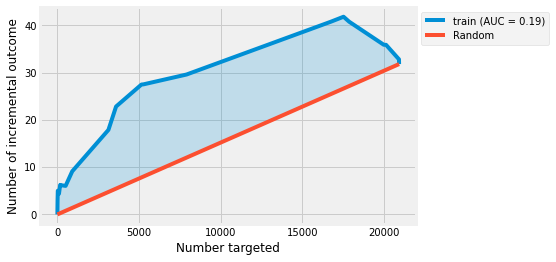

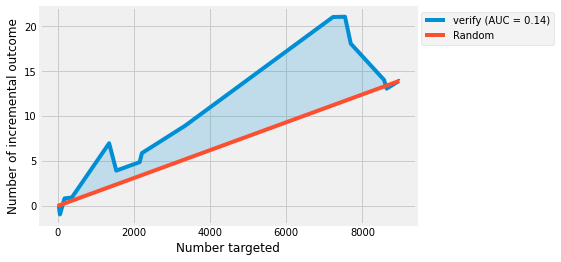

In [21]:
#fig, ax = plt.subplots(1, 1)
#ax.set_title('Qini curves')
plot_qini_curve(X_train[y_columns], X_train['uplift'], X_train[treatment], perfect=False, name='train')
plot_qini_curve(X_verify[y_columns], X_verify['uplift'], X_verify[treatment], perfect=False, name='verify')
print(qini_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment]))
print(qini_auc_score(X_verify[y_columns], X_verify['uplift'], X_verify[treatment]))
#print(uplift_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment]))
#print(auuc_score(X_train[[y_columns, treatment, 'uplift']], outcome_col=y_columns, treatment_col=treatment))

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0031'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

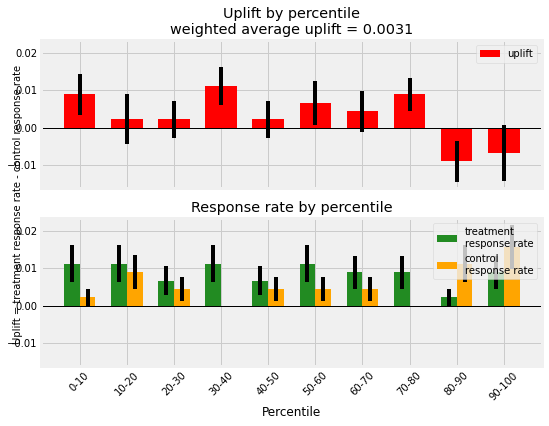

In [22]:
plot_uplift_by_percentile(X_verify[y_columns], X_verify['uplift'], X_verify[treatment], \
                          strategy='by_group', kind='bar')

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor,CatBoostClassifier

#search_params = {'learning_rate': [0.001,0.005,0.01], 'n_estimators':[100,200], 
#                'subsample':[0.4,0.5], 'max_depth': [2,3,5]}

search_params = {'learning_rate': [0.005], 'n_estimators':[100], 
                'subsample':[0.5], 'max_depth': [3]}

best_result=[{'auc_score':0, 'monotonicity':0}]
best_params={}
for learning_rate in search_params['learning_rate']:
    print('learning_rate: %s' % learning_rate)
    for n_estimators in search_params['n_estimators']:
        print('n_estimators: %s' % n_estimators)
        for subsample in search_params['subsample']:
            print('subsample: %s' % subsample)
            for max_depth in search_params['max_depth']:
                print('max_depth: %s' % max_depth)

                model1 = XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                      subsample=subsample, max_depth=max_depth) 
                model1.fit(X_train_exp[X_columns],X_train_exp[y_columns])

                y_train_pred1 = model1.predict(X_train[X_columns])
                y_verify_pred1 = model1.predict(X_verify[X_columns])
                
                model2 = XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                      subsample=subsample, max_depth=max_depth) 
                model2.fit(X_train_base[X_columns],X_train_base[y_columns])

                y_train_pred2 = model2.predict(X_train[X_columns])
                y_verify_pred2= model2.predict(X_verify[X_columns])

                X_train['uplift'] = y_train_pred1 - y_train_pred2
                X_verify['uplift'] = y_verify_pred1 - y_verify_pred2
                    
                train_qini_auc_score = qini_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment])
                verify_qini_auc_score = qini_auc_score(X_verify[y_columns], X_verify['uplift'], X_verify[treatment])
                    
                new_df_train = plot_uplift(X_train, treatment=treatment, metric=y_columns, bins=10, is_plot=False)
                monotonicity_train = spearmanr(new_df_train[new_df_train['type']=='actual'].index,new_df_train[new_df_train['type']=='actual']['uplift_score'])[0]
                    
                new_df_verify = plot_uplift(X_verify, treatment=treatment, metric=y_columns, bins=10, is_plot=False)
                monotonicity_verify = spearmanr(new_df_verify[new_df_verify['type']=='actual'].index,new_df_verify[new_df_verify['type']=='actual']['uplift_score'])[0]
                    
                print('train_qini_auc_score: %s, verify_qini_auc_score: %s' % (train_qini_auc_score, verify_qini_auc_score))
                print('monotonicity_train: %s, monotonicity_verify: %s' % (monotonicity_train, monotonicity_verify))
                    
                pareto_result(verify_qini_auc_score, monotonicity_verify, best_result,\
                             {'learning_rate': learning_rate,'n_estimators': n_estimators, \
                              'subsample':subsample, 'max_depth':max_depth})
                        
print(best_result)


learning_rate: 0.005
n_estimators: 100
subsample: 0.5
max_depth: 3
train_qini_auc_score: 0.2174183602448004, verify_qini_auc_score: 0.13072312918110812
monotonicity_train: 1.0, monotonicity_verify: 0.6000000000000001
[{'auc_score': 0.13072312918110812, 'monotonicity': 0.6000000000000001, 'params': {'learning_rate': 0.005, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 3}}]


In [26]:
'''
best_params:
learning_rate: 0.01
n_estimators: 40
subsample: 0.4
max_depth: 2
'''

'\nbest_params:\nlearning_rate: 0.01\nn_estimators: 40\nsubsample: 0.4\nmax_depth: 2\n'

In [34]:
# 模型保存
dump(model1, 'result/womens_conversion/xgb_model1.joblib')
dump(model2, 'result/womens_conversion/xgb_model2.joblib')

['result/womens_conversion/xgb_model2.joblib']

0.2174183602448004
0.13072312918110812


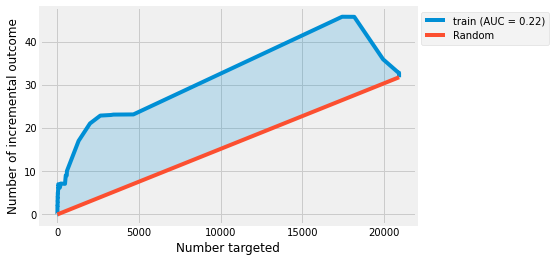

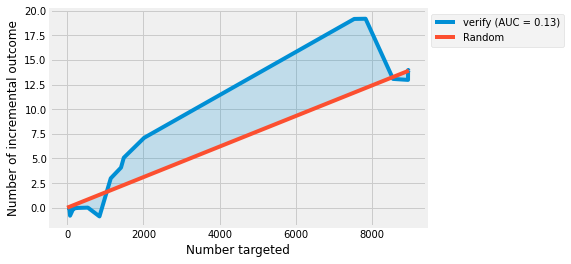

In [28]:
#fig, ax = plt.subplots(1, 1)
#ax.set_title('Qini curves')
plot_qini_curve(X_train[y_columns], X_train['uplift'], X_train[treatment], perfect=False, name='train')
plot_qini_curve(X_verify[y_columns], X_verify['uplift'], X_verify[treatment], perfect=False, name='verify')
print(qini_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment]))
print(qini_auc_score(X_verify[y_columns], X_verify['uplift'], X_verify[treatment]))
#print(uplift_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment]))
#print(auuc_score(X_train[[y_columns, treatment, 'uplift']], outcome_col=y_columns, treatment_col=treatment))

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0031'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

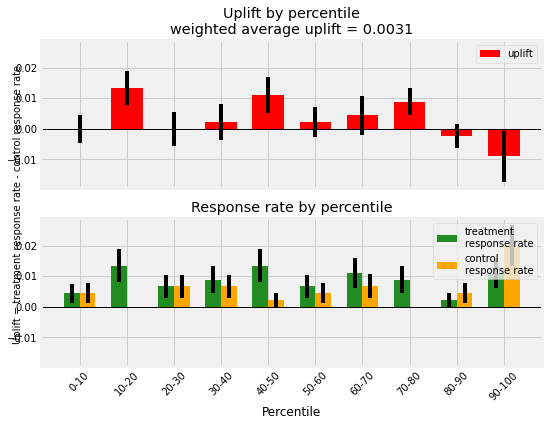

In [29]:
plot_uplift_by_percentile(X_verify[y_columns], X_verify['uplift'], X_verify[treatment], \
                          strategy='by_group', kind='bar')

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor,CatBoostClassifier

#search_params = {'learning_rate': [0.001,0.002,0.003,0.004,0.005], 'n_estimators':[30,40,50,60], 
#                'subsample':[0.3], 'max_depth': [5]}

search_params = {'learning_rate': [0.003], 'n_estimators':[50], 
                'subsample':[0.3], 'max_depth': [5]}

best_result=[{'auc_score':0, 'monotonicity':0}]
best_params={}
for learning_rate in search_params['learning_rate']:
    print('learning_rate: %s' % learning_rate)
    for n_estimators in search_params['n_estimators']:
        print('n_estimators: %s' % n_estimators)
        for subsample in search_params['subsample']:
            print('subsample: %s' % subsample)
            for max_depth in search_params['max_depth']:
                print('max_depth: %s' % max_depth)

                model1 = CatBoostRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                      subsample=subsample, max_depth=max_depth) 
                model1.fit(X_train_exp[X_columns],X_train_exp[y_columns])

                y_train_pred1 = model1.predict(X_train[X_columns])
                y_verify_pred1 = model1.predict(X_verify[X_columns])
                
                model2 = CatBoostRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                      subsample=subsample, max_depth=max_depth) 
                model2.fit(X_train_base[X_columns],X_train_base[y_columns])

                y_train_pred2 = model2.predict(X_train[X_columns])
                y_verify_pred2= model2.predict(X_verify[X_columns])

                X_train['uplift'] = y_train_pred1 - y_train_pred2
                X_verify['uplift'] = y_verify_pred1 - y_verify_pred2
                    
                train_qini_auc_score = qini_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment])
                verify_qini_auc_score = qini_auc_score(X_verify[y_columns], X_verify['uplift'], X_verify[treatment])
                    
                new_df_train = plot_uplift(X_train, treatment=treatment, metric=y_columns, bins=10, is_plot=False)
                monotonicity_train = spearmanr(new_df_train[new_df_train['type']=='actual'].index,new_df_train[new_df_train['type']=='actual']['uplift_score'])[0]
                    
                new_df_verify = plot_uplift(X_verify, treatment=treatment, metric=y_columns, bins=10, is_plot=False)
                monotonicity_verify = spearmanr(new_df_verify[new_df_verify['type']=='actual'].index,new_df_verify[new_df_verify['type']=='actual']['uplift_score'])[0]
                    
                print('train_qini_auc_score: %s, verify_qini_auc_score: %s' % (train_qini_auc_score, verify_qini_auc_score))
                print('monotonicity_train: %s, monotonicity_verify: %s' % (monotonicity_train, monotonicity_verify))
                    
                pareto_result(verify_qini_auc_score, monotonicity_verify, best_result, \
                              {'learning_rate':learning_rate,'n_estimators': n_estimators, \
                              'subsample':subsample, 'max_depth':max_depth})
                        
print(best_result)

learning_rate: 0.003
n_estimators: 50
subsample: 0.3
max_depth: 5
0:	learn: 0.0922741	total: 1.14ms	remaining: 56.1ms
1:	learn: 0.0922713	total: 2.24ms	remaining: 53.8ms
2:	learn: 0.0922704	total: 3.37ms	remaining: 52.8ms
3:	learn: 0.0922684	total: 4.62ms	remaining: 53.2ms
4:	learn: 0.0922671	total: 5.8ms	remaining: 52.2ms
5:	learn: 0.0922656	total: 7ms	remaining: 51.3ms
6:	learn: 0.0922631	total: 8.14ms	remaining: 50ms
7:	learn: 0.0922604	total: 9.29ms	remaining: 48.8ms
8:	learn: 0.0922585	total: 10.8ms	remaining: 49.3ms
9:	learn: 0.0922572	total: 12.1ms	remaining: 48.6ms
10:	learn: 0.0922556	total: 13.5ms	remaining: 47.9ms
11:	learn: 0.0922532	total: 14.7ms	remaining: 46.6ms
12:	learn: 0.0922528	total: 15.8ms	remaining: 44.9ms
13:	learn: 0.0922504	total: 17.1ms	remaining: 44.1ms
14:	learn: 0.0922488	total: 18.6ms	remaining: 43.4ms
15:	learn: 0.0922477	total: 19.8ms	remaining: 42.1ms
16:	learn: 0.0922455	total: 21.1ms	remaining: 41ms
17:	learn: 0.0922446	total: 22.3ms	remaining: 39.7m

In [40]:
# 模型保存
dump(model1, 'result/womens_conversion/cat_boost_model1.joblib')
dump(model2, 'result/womens_conversion/cat_boost_model2.joblib')

['result/womens_conversion/cat_boost_model2.joblib']

In [41]:
# best_params
#{'learning_rate': 0.02, 'n_estimators': 50, 'subsample': 0.4, 'max_depth': 2}

0.35533374407337326
0.1826303093475036


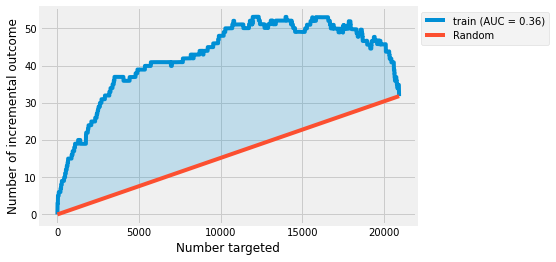

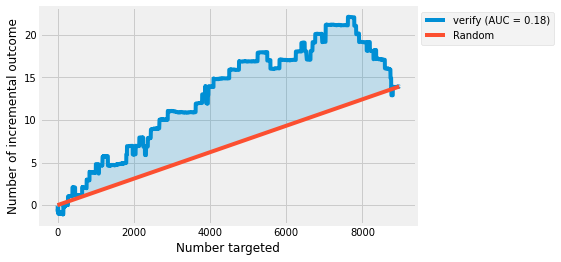

In [42]:
#fig, ax = plt.subplots(1, 1)
#ax.set_title('Qini curves')
plot_qini_curve(X_train[y_columns], X_train['uplift'], X_train[treatment], perfect=False, name='train')
plot_qini_curve(X_verify[y_columns], X_verify['uplift'], X_verify[treatment], perfect=False, name='verify')
print(qini_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment]))
print(qini_auc_score(X_verify[y_columns], X_verify['uplift'], X_verify[treatment]))
#print(uplift_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment]))
#print(auuc_score(X_train[[y_columns, treatment, 'uplift']], outcome_col=y_columns, treatment_col=treatment))

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0031'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

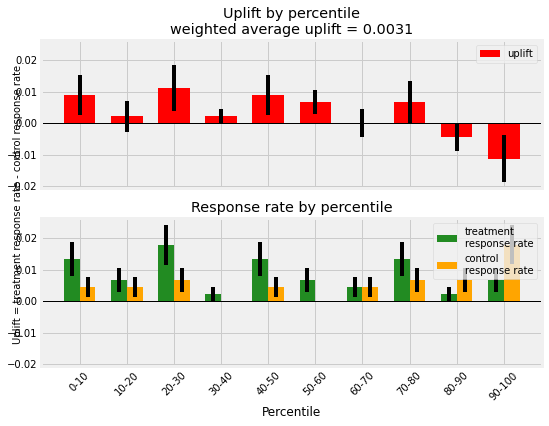

In [43]:
plot_uplift_by_percentile(X_verify[y_columns], X_verify['uplift'], X_verify[treatment], \
                          strategy='by_group', kind='bar')

#### Part3 因果森林

In [55]:
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor,CatBoostClassifier

search_params = {'n_estimators':[20], 
                'min_samples_leaf': [1], 'max_depth': [2],
                'max_samples': [0.3]}

#search_params = {
#    'n_estimators': [20],
#    'min_samples_leaf': [1],
#    'max_depth': [2],
#    'max_samples': [0.5]
#}

best_result=[{'auc_score':0, 'monotonicity':0}]
best_params={}
for max_samples in search_params['max_samples']:
    print('max_samples: %s' % max_samples)
    for n_estimators in search_params['n_estimators']:
        print('n_estimators: %s' % n_estimators)
        for min_samples_leaf in search_params['min_samples_leaf']:
            print('min_samples_leaf: %s' % min_samples_leaf)
            for max_depth in search_params['max_depth']:
                print('max_depth: %s' % max_depth)

                model = CausalForestDML(criterion='het', 
                                max_depth=max_depth,
                                n_estimators=n_estimators,  
                                min_samples_leaf=min_samples_leaf, 
                                max_samples=max_samples,
                                discrete_treatment=True,
                                honest=True,
                                inference=True,
                                cv=5)
                model.fit(X_train[y_columns], X_train[[treatment]], X=X_train[X_columns], W=None, cache_values=True)
                X_train['uplift'] = model.effect(X_train[X_columns])
                X_verify['uplift'] = model.effect(X_verify[X_columns])
                    
                train_qini_auc_score = qini_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment])
                verify_qini_auc_score = qini_auc_score(X_verify[y_columns], X_verify['uplift'], X_verify[treatment])
                    
                new_df_train = plot_uplift(X_train, treatment=treatment, metric=y_columns, bins=10, is_plot=False)
                monotonicity_train = spearmanr(new_df_train[new_df_train['type']=='actual'].index,new_df_train[new_df_train['type']=='actual']['uplift_score'])[0]
                    
                new_df_verify = plot_uplift(X_verify, treatment=treatment, metric=y_columns, bins=10, is_plot=False)
                monotonicity_verify = spearmanr(new_df_verify[new_df_verify['type']=='actual'].index,new_df_verify[new_df_verify['type']=='actual']['uplift_score'])[0]
                    
                print('train_qini_auc_score: %s, verify_qini_auc_score: %s' % (train_qini_auc_score, verify_qini_auc_score))
                print('monotonicity_train: %s, monotonicity_verify: %s' % (monotonicity_train, monotonicity_verify))
                    
                pareto_result(verify_qini_auc_score, monotonicity_verify, best_result, \
                             {'max_samples':max_samples,'n_estimators': n_estimators, \
                              'min_samples_leaf':min_samples_leaf, 'max_depth':max_depth})
                        
print(best_result)

max_samples: 0.3
n_estimators: 20
min_samples_leaf: 1
max_depth: 2
train_qini_auc_score: 0.21674834480087607, verify_qini_auc_score: 0.17091077249225614
monotonicity_train: 0.8787878787878788, monotonicity_verify: 0.7333333333333332
[{'auc_score': 0.17091077249225614, 'monotonicity': 0.7333333333333332, 'params': {'max_samples': 0.3, 'n_estimators': 20, 'min_samples_leaf': 1, 'max_depth': 2}}]


In [56]:
# 模型保存
dump(model, 'result/womens_conversion/causal_forest_model.joblib')

['result/womens_conversion/causal_forest_model.joblib']

0.21674834480087607
0.17091077249225614


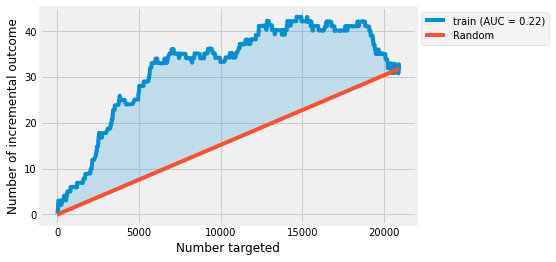

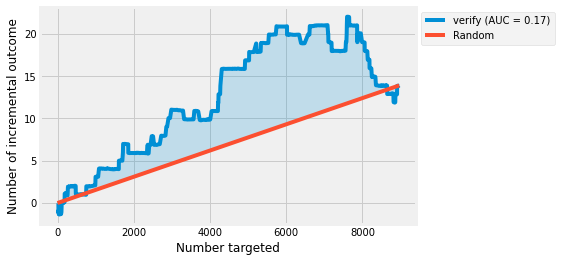

In [57]:
#fig, ax = plt.subplots(1, 1)
#ax.set_title('Qini curves')
plot_qini_curve(X_train[y_columns], X_train['uplift'], X_train[treatment], perfect=False, name='train')
plot_qini_curve(X_verify[y_columns], X_verify['uplift'], X_verify[treatment], perfect=False, name='verify')
print(qini_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment]))
print(qini_auc_score(X_verify[y_columns], X_verify['uplift'], X_verify[treatment]))
#print(uplift_auc_score(X_train[y_columns], X_train['uplift'], X_train[treatment]))
#print(auuc_score(X_train[[y_columns, treatment, 'uplift']], outcome_col=y_columns, treatment_col=treatment))

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0031'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

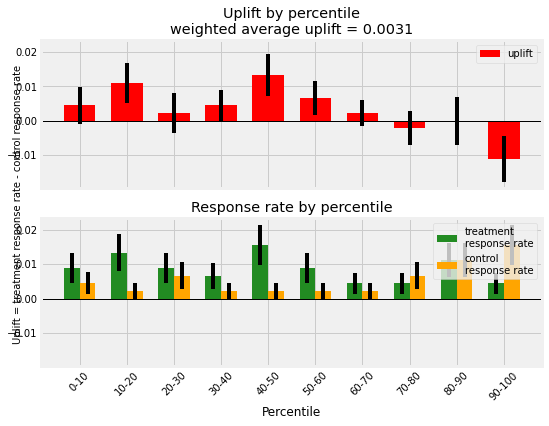

In [58]:
plot_uplift_by_percentile(X_verify[y_columns], X_verify['uplift'], X_verify[treatment], \
                          strategy='by_group', kind='bar')

In [59]:
# 连续变量
#plot_gain(X_train[[y_columns, treatment, 'uplift']], outcome_col=y_columns, treatment_col=treatment)
#auuc_score(X_train[[y_columns, treatment, 'uplift']], outcome_col=y_columns, treatment_col=treatment)

In [60]:
## 多模型比较
gbdt_model1 = load('result/womens_conversion/gbdt_model1.joblib')
gbdt_model2 = load('result/womens_conversion/gbdt_model2.joblib')

X_test['gbdt_uplift'] = gbdt_model1.predict(X_test[X_columns]) - gbdt_model2.predict(X_test[X_columns])

xgb_model1 = load('result/womens_conversion/xgb_model1.joblib')
xgb_model2 = load('result/womens_conversion/xgb_model2.joblib')

X_test['xgb_uplift'] = xgb_model1.predict(X_test[X_columns]) - xgb_model2.predict(X_test[X_columns])

cat_boost_model1 = load('result/womens_conversion/cat_boost_model1.joblib')
cat_boost_model2 = load('result/womens_conversion/cat_boost_model2.joblib')

X_test['cat_boost_uplift'] = cat_boost_model1.predict(X_test[X_columns]) - cat_boost_model2.predict(X_test[X_columns])

causal_forest_model = load('result/womens_conversion/causal_forest_model.joblib')
X_test['causal_forest_uplift'] = causal_forest_model.effect(X_test[X_columns])
#X_test['causal_forest_uplift'] = causal_forest_model.const_marginal_effect(X_test[X_columns])

GBDT QINI SCORE: 0.07342695439049825
XGB QINI SCORE: 0.07342695439049825
CAT BOOST QINI SCORE: 0.01833087506738874
CAUSAL FOREST SCORE: 0.11331730375680851


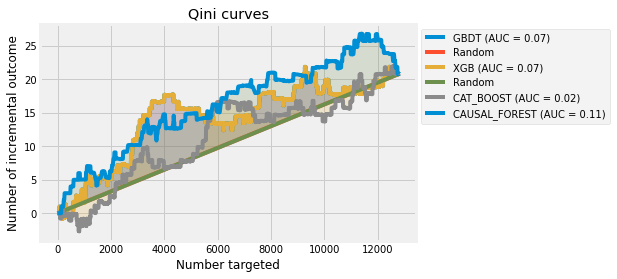

In [74]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Qini curves')
plot_qini_curve(X_test[y_columns], X_test['gbdt_uplift'], X_test[treatment], perfect=False, name='GBDT', ax=ax)
plot_qini_curve(X_test[y_columns], X_test['xgb_uplift'], X_test[treatment], perfect=False, name='XGB', ax=ax)
plot_qini_curve(X_test[y_columns], X_test['cat_boost_uplift'], X_test[treatment], perfect=False, name='CAT_BOOST', ax=ax)
plot_qini_curve(X_test[y_columns], X_test['causal_forest_uplift'], X_test[treatment], perfect=False, name='CAUSAL_FOREST', ax=ax)
print('GBDT QINI SCORE: %s' % qini_auc_score(X_test[y_columns], X_test['gbdt_uplift'], X_test[treatment]))
print('XGB QINI SCORE: %s' % qini_auc_score(X_test[y_columns], X_test['xgb_uplift'], X_test[treatment]))
print('CAT BOOST QINI SCORE: %s' % qini_auc_score(X_test[y_columns], X_test['cat_boost_uplift'], X_test[treatment]))
print('CAUSAL FOREST SCORE: %s' % qini_auc_score(X_test[y_columns], X_test['causal_forest_uplift'], X_test[treatment]))

## 第四部分：收益回归
uplift排名前15%的人群收益和uplift排名后15%的人群收益（也用来衡量偏序关系寻优的效果）

In [62]:
bottom = np.percentile(X_test['causal_forest_uplift'], 15.6)
up = np.percentile(X_test['causal_forest_uplift'], 100-15.6)

In [63]:
up

In [64]:
good = X_test[X_test['causal_forest_uplift']>=up]
bad = X_test[X_test['causal_forest_uplift']<=bottom]
print(len(good))
print(len(bad))
print(len(X_test))

2019
2008
12809


In [65]:
good_exp = good[good[treatment]==1]
good_base = good[good[treatment]==0]
print('good人群对visit的处理效应：%s' % (good_exp['visit'].mean() - good_base['visit'].mean()))
print('good人群对conversion的处理效应：%s' % (good_exp['conversion'].mean() - good_base['conversion'].mean()))
print('good人群对spend的处理效应：%s' % (good_exp['spend'].mean() - good_base['spend'].mean()))

good人群对visit的处理效应：0.06731471662542714
good人群对conversion的处理效应：0.006347943914221751
good人群对spend的处理效应：0.18754710144927533


In [66]:
bad_exp = bad[bad[treatment]==1]
bad_base = bad[bad[treatment]==0]
print('bad人群对visit的处理效应：%s' % (bad_exp['visit'].mean() - bad_base['visit'].mean()))
print('bad人群对conversion的处理效应：%s' % (bad_exp['conversion'].mean() - bad_base['conversion'].mean()))
print('bad人群对spend的处理效应：%s' % (bad_exp['spend'].mean() - bad_base['spend'].mean()))

bad人群对visit的处理效应：0.05272870685934547
bad人群对conversion的处理效应：-0.0037880930057198415
bad人群对spend的处理效应：-0.523807053314085


## 第五部分：提炼人群共性

In [72]:
label = 'causal_forest_uplift'

search_params = {'criterion': ['mse'],
                'max_depth': [9,10,11,None],
                #'max_features': ['sqrt','auto','log2'],
                'max_features': ['auto'],
                'min_impurity_decrease': [0]}

tree_train, tree_test = train_test_split(X_test, test_size=0.3, random_state=0)

best_score = 0
best_params = {}
best_model = None

for criterion in search_params['criterion']:
    print('criterion: %s' % criterion)
    for max_depth in search_params['max_depth']:
        print('max_depth: %s' % max_depth)
        for max_features in search_params['max_features']:
            print('max_features: %s' % max_features)
            for min_impurity_decrease in search_params['min_impurity_decrease']:
                print('min_impurity_decrease: %s' % min_impurity_decrease)
                tree_model = DecisionTreeRegressor(criterion=criterion,
                                                 splitter='best',
                                                 max_depth=max_depth,
                                                 min_samples_split=2,
                                                 min_samples_leaf=1,
                                                 min_weight_fraction_leaf=0,
                                                 max_features=max_features,
                                                 random_state=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=min_impurity_decrease)
                tree_model.fit(tree_train[X_columns], tree_train[label])
                
                tree_train_score = tree_model.score(tree_train[X_columns], tree_train[label])
                tree_test_score = tree_model.score(tree_test[X_columns], tree_test[label])
                
                print('tree_train_score: %s, tree_test_score: %s' % (tree_train_score, tree_test_score))
                
                if tree_test_score > best_score:
                    best_score = tree_test_score
                    best_params = {'criterion': criterion, 'max_depth': max_depth, 
                                  'max_features': max_features, 'min_impurity_decrease': min_impurity_decrease}
                    best_model = tree_model
    
print(best_score)
print(best_params)

criterion: mse
max_depth: 9
max_features: auto
min_impurity_decrease: 0
tree_train_score: 0.9520780198496085, tree_test_score: 0.937157228189353
max_depth: 10
max_features: auto
min_impurity_decrease: 0
tree_train_score: 0.9749553021348409, tree_test_score: 0.9585057038110103
max_depth: 11
max_features: auto
min_impurity_decrease: 0
tree_train_score: 0.988067688727908, tree_test_score: 0.9700824293593749
max_depth: None
max_features: auto
min_impurity_decrease: 0
tree_train_score: 1.0, tree_test_score: 0.978846536180123
0.978846536180123
{'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'min_impurity_decrease': 0}


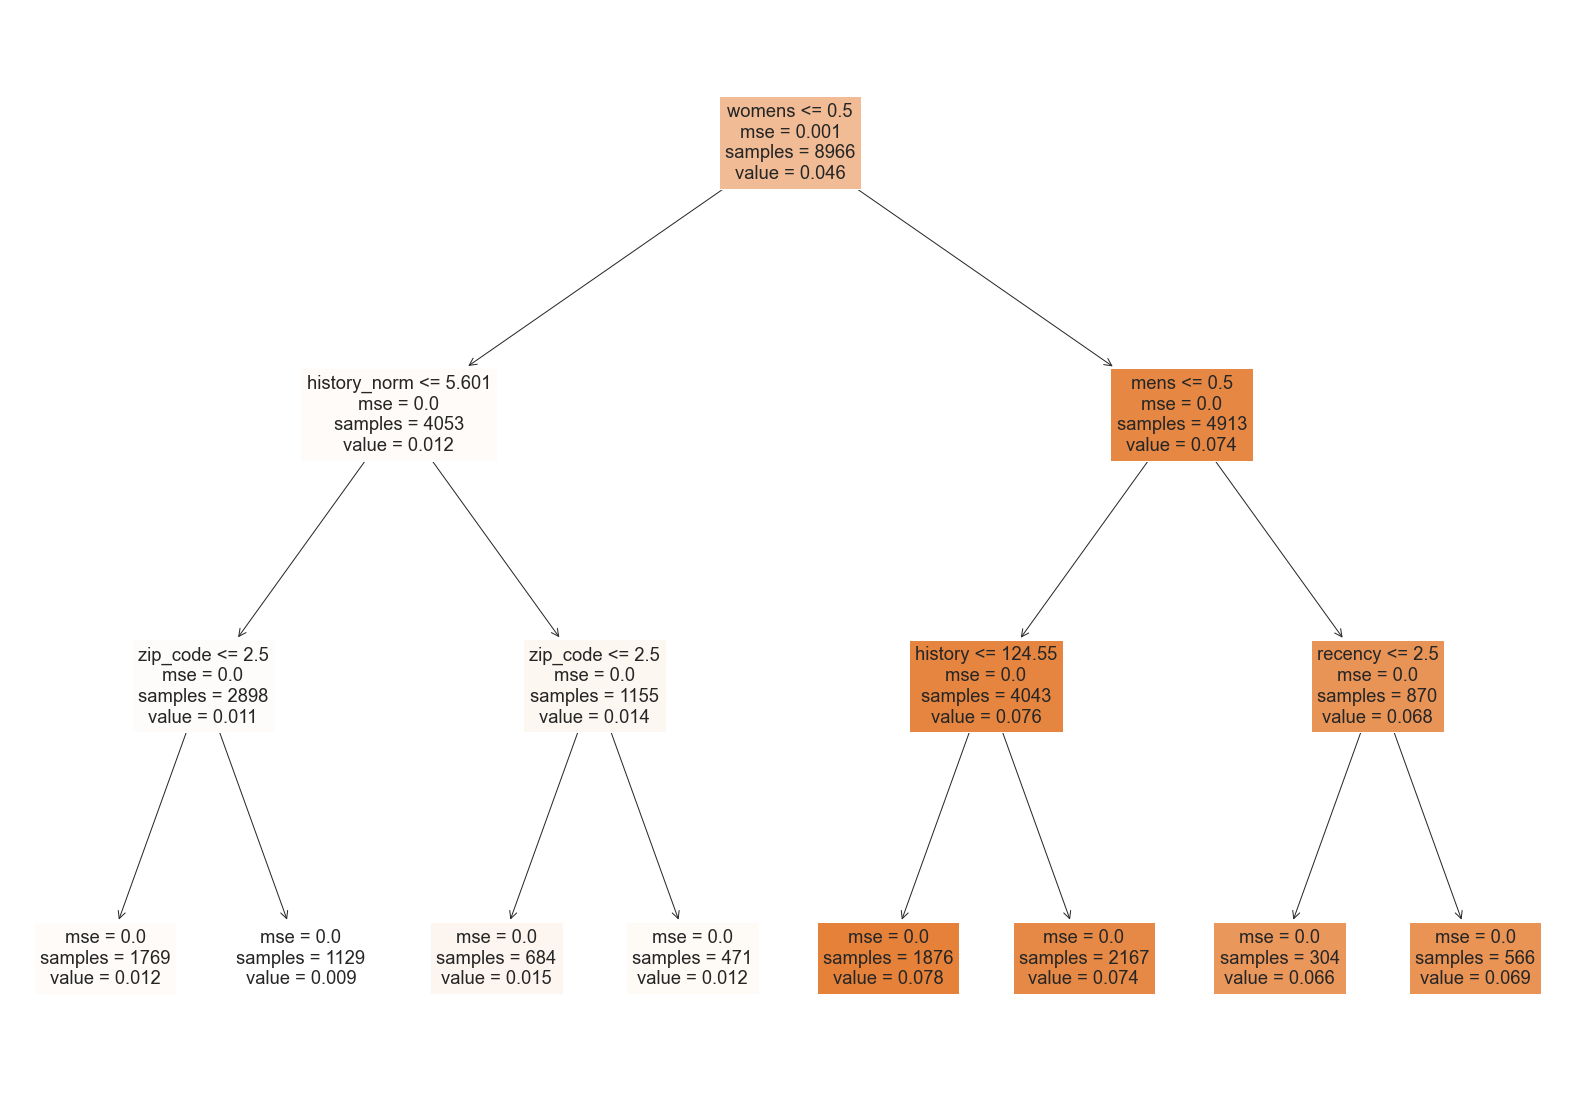

In [165]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model, 
                   feature_names=X_columns,  
                   filled=True)